# Pipeline

In [2]:
# libraries importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# additional modules
import sys
sys.path.append('../Algoritmos')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from utils_functions import graficar_matriz_confusion, plot_cut, create_sequences

## Cargar SKAB data

In [3]:
path_to_data = '../data/'

all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [4]:
# datasets with anomalies loading
all_fault_data = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

In [4]:
other_df = all_fault_data[0:15]
valve1_df = all_fault_data[15:31]
valve2_df = all_fault_data[31:36]

## Definir arquitecturas

In [6]:

from LSTM_AE import LSTM_AE 
from sklearn.preprocessing import StandardScaler

In [9]:
N_STEPS = 40
Q = 0.9 # quantile for upper control limit (UCL) selection
PARAM = {"EPOCHS": 100,
         "BATCH_SIZE": 16,
         "input_shape": (None, N_STEPS, 8), 
         "VAL_SPLIT":0.1}

model = LSTM_AE(PARAM)
# model = Conv_AE()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 40, 16)            1600      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVecto  (None, 40, 4)             0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 40, 4)             144       
                                                                 
 lstm_3 (LSTM)               (None, 40, 16)            1344      
                                                             

### Train-Test All Faults Data

In [12]:
#=================TRAIN ON HEALTHY DATA=================
train_data = anomaly_free_df
X_train = train_data

# scaler init and fitting
StSc = StandardScaler()
StSc.fit(X_train)

# convert into input/output
X = create_sequences(StSc.transform(X_train), N_STEPS)

# model fitting
# history, model = arch(X)
model.fit(X)

# results predicting
residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)[1]), axis=1), axis=1))
UCL = residuals.quantile(Q) * 3/2

293/293 [==============================] - 2s 5ms/step


In [13]:
%%time
list_of_df = all_fault_data
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    # results predicting
    X = create_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
    cnn_residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)[1]), axis=1), axis=1))
    
    # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
    anomalous_data = cnn_residuals > UCL
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)
    
    prediction = pd.Series(data=0, index=df.index)
    prediction.iloc[anomalous_data_indices] = 1
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

30/30 [==============================] - 0s 5ms/step
CPU times: total: 2.84 s
Wall time: 9.21 s


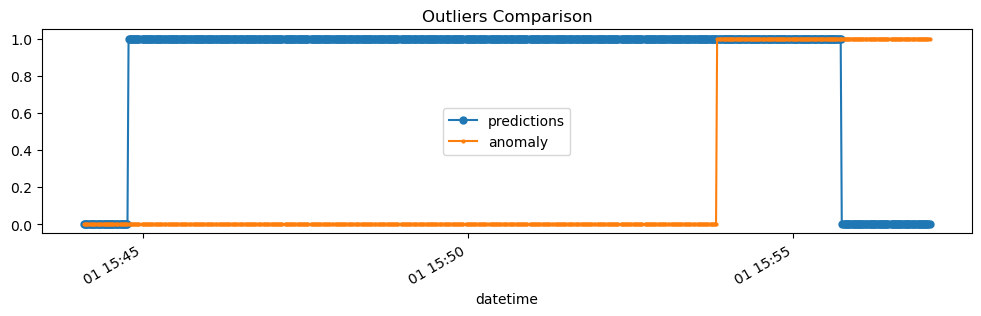

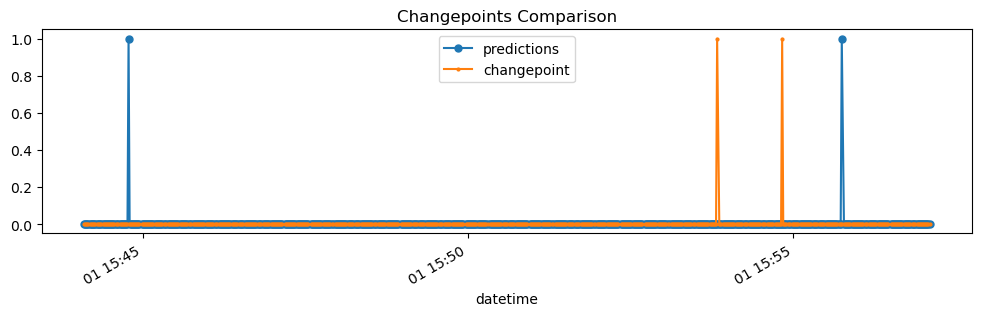

Since you not choose numenta_time and portion, then portion will be 0.1
False Alarm Rate 74.74 %
Missing Alarm Rate 5.07 %
F1 metric 0.57
Since you not choose numenta_time and portion, then portion will be 0.1
TP 12405
TN 6147
FP 18187
FN 662


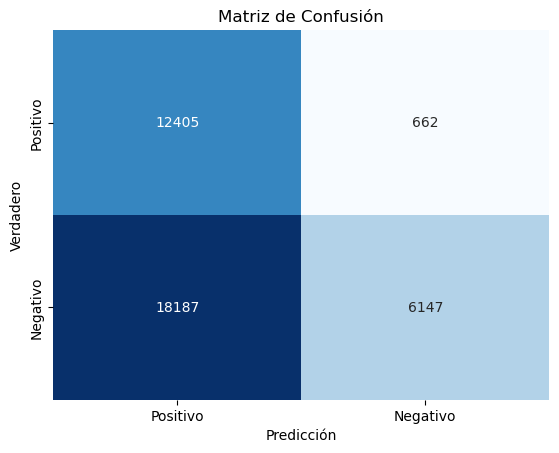

Intersection of scoring windows(Timestamp('2020-03-01 15:58:10'), Timestamp('2020-03-01 15:54:50'))
Intersection of scoring windows(Timestamp('2020-02-08 18:02:23.600000'), Timestamp('2020-02-08 17:58:38'))
Intersection of scoring windows(Timestamp('2020-02-08 18:09:01.600000'), Timestamp('2020-02-08 18:08:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:24:52.800000'), Timestamp('2020-02-08 18:20:46'))
Intersection of scoring windows(Timestamp('2020-02-08 18:31:06.800000'), Timestamp('2020-02-08 18:28:37'))
Intersection of scoring windows(Timestamp('2020-02-08 18:48:51.600000'), Timestamp('2020-02-08 18:46:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:55:37.600000'), Timestamp('2020-02-08 18:51:55'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:15.800000'), Timestamp('2020-02-08 18:58:30'))
Intersection of scoring windows(Timestamp('2020-02-08 19:06:15.800000'), Timestamp('2020-02-08 19:03:36'))
Intersection of scoring windows(Timestamp('2

In [14]:
# %pip install tsad
from tsad.evaluating.evaluating import evaluating
from utils_functions import graficar_matriz_confusion

# Trazar outliers
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

plt.figure(figsize=(12,3))  # Crea una nueva figura para los outliers
predicted_outlier[0].plot(label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend()
plt.title('Outliers Comparison')
plt.show()  # Muestra la figura de outliers

# Trazar changepoints

true_cp = [df.changepoint for df in list_of_df]

plt.figure(figsize=(12,3))  # Crea una nueva figura para los changepoints
predicted_cp[0].plot(label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend()
plt.title('Changepoints Comparison')
plt.show()  # Muestra la figura de changepoints


# binary classification metrics calculation
binary = evaluating(
    true_outlier, 
    predicted_outlier, 
    metric='binary'
)

conf_matrix = evaluating(
    true_outlier, 
    predicted_outlier, 
    metric='confusion_matrix'
)
graficar_matriz_confusion(conf_matrix)


# average detection delay metric calculation
add = evaluating(
    true_cp, 
    predicted_cp, 
    metric='average_time',
    anomaly_window_destenation='righter', 
    portion=1
)

# nab metric calculation
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='30S',
    anomaly_window_destenation='center', 
)

### Train-Test Other Faults Data

In [103]:
%%time
list_of_df = other_df
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:500].drop(['anomaly','changepoint'], axis=1)
    
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # convert into input/output
    X = create_sequences(StSc.transform(X_train), N_STEPS)
    
    # model fitting
    # history, model = arch(X)
    model.fit(X)
    
    # results predicting
    residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)[1]), axis=1), axis=1))
    UCL = residuals.quantile(Q) * 3/2
    
    # results predicting
    X = create_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
    cnn_residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)[1]), axis=1), axis=1))
    
    # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
    anomalous_data = cnn_residuals > UCL
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)
    
    prediction = pd.Series(data=0, index=df.index)
    prediction.iloc[anomalous_data_indices] = 1
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

36/36 [==============================] - 0s 7ms/step
CPU times: total: 1min 51s
Wall time: 6min 26s


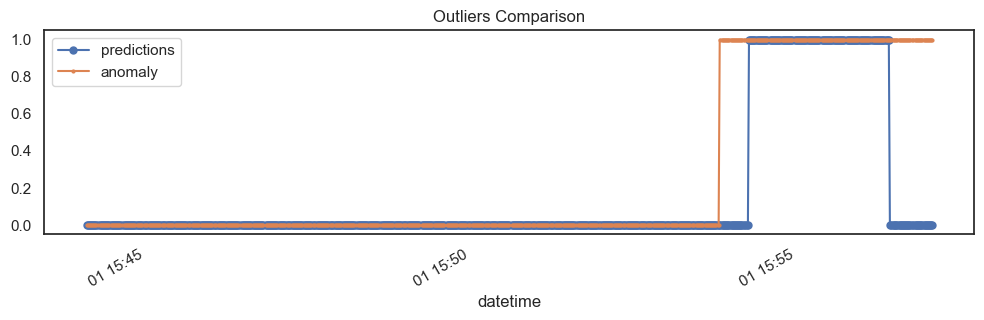

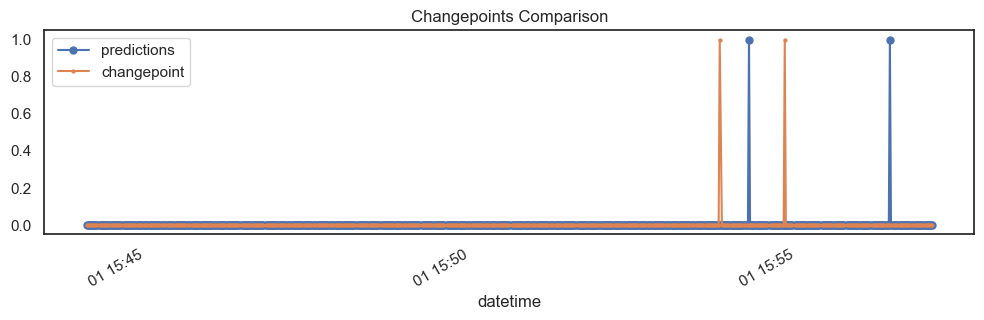

Since you not choose numenta_time and portion, then portion will be 0.1
False Alarm Rate 9.56 %
Missing Alarm Rate 30.98 %
F1 metric 0.74
Since you not choose numenta_time and portion, then portion will be 0.1
TP 3894
TN 9437
FP 997
FN 1748


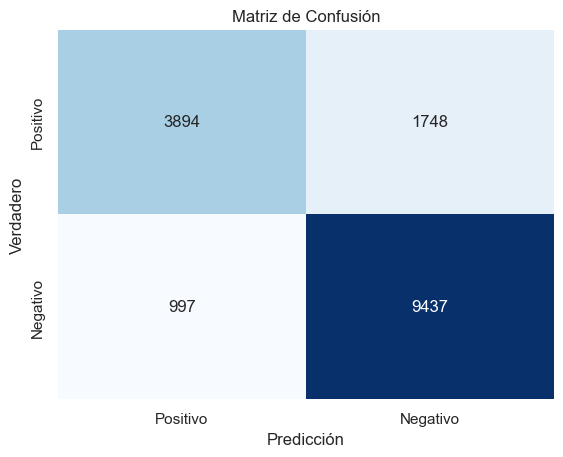

Intersection of scoring windows(Timestamp('2020-03-01 15:58:10'), Timestamp('2020-03-01 15:54:50'))
Intersection of scoring windows(Timestamp('2020-02-08 18:02:23.600000'), Timestamp('2020-02-08 17:58:38'))
Intersection of scoring windows(Timestamp('2020-02-08 18:09:01.600000'), Timestamp('2020-02-08 18:08:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:24:52.800000'), Timestamp('2020-02-08 18:20:46'))
Intersection of scoring windows(Timestamp('2020-02-08 18:31:06.800000'), Timestamp('2020-02-08 18:28:37'))
Intersection of scoring windows(Timestamp('2020-02-08 18:48:51.600000'), Timestamp('2020-02-08 18:46:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:55:37.600000'), Timestamp('2020-02-08 18:51:55'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:15.800000'), Timestamp('2020-02-08 18:58:30'))
Intersection of scoring windows(Timestamp('2020-02-08 19:06:15.800000'), Timestamp('2020-02-08 19:03:36'))
Intersection of scoring windows(Timestamp('2

In [104]:
# Trazar outliers
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

plt.figure(figsize=(12,3))  # Crea una nueva figura para los outliers
predicted_outlier[0].plot(label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend()
plt.title('Outliers Comparison')
plt.show()  # Muestra la figura de outliers

# Trazar changepoints

true_cp = [df.changepoint for df in list_of_df]

plt.figure(figsize=(12,3))  # Crea una nueva figura para los changepoints
predicted_cp[0].plot(label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend()
plt.title('Changepoints Comparison')
plt.show()  # Muestra la figura de changepoints


# binary classification metrics calculation
binary = evaluating(
    true_outlier, 
    predicted_outlier, 
    metric='binary'
)

conf_matrix = evaluating(
    true_outlier, 
    predicted_outlier, 
    metric='confusion_matrix'
)
graficar_matriz_confusion(conf_matrix)


# average detection delay metric calculation
add = evaluating(
    true_cp, 
    predicted_cp, 
    metric='average_time',
    anomaly_window_destenation='righter', 
    portion=1
)

# nab metric calculation
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='30S',
    anomaly_window_destenation='center', 
)

### Train-Test Valve1 Fault Data

In [144]:
%%time
list_of_df = valve1_df
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:500].drop(['anomaly','changepoint'], axis=1)
    
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # convert into input/output
    X = create_sequences(StSc.transform(X_train), N_STEPS)
    
    # model fitting
    # history, model = arch(X)
    model.fit(X)
    
    # results predicting
    residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)[1]), axis=1), axis=1))
    UCL = residuals.quantile(Q) * 3/2
    
    # results predicting
    X = create_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
    cnn_residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)[1]), axis=1), axis=1))
    
    # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
    anomalous_data = cnn_residuals > UCL
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)
    
    prediction = pd.Series(data=0, index=df.index)
    prediction.iloc[anomalous_data_indices] = 1
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

34/34 [==============================] - 1s 19ms/step
CPU times: total: 2min 45s
Wall time: 11min 2s


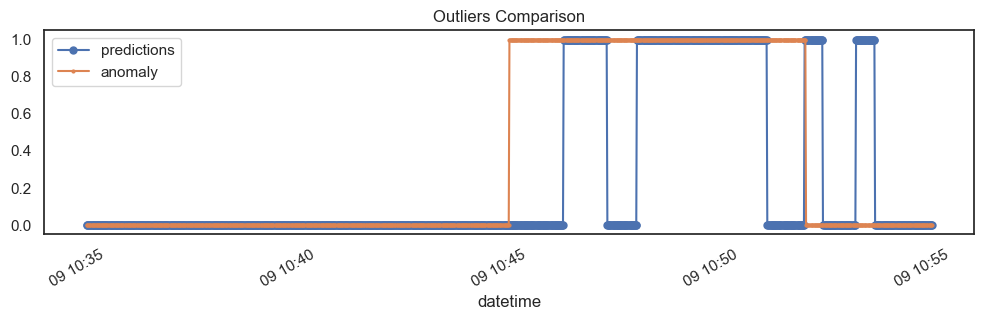

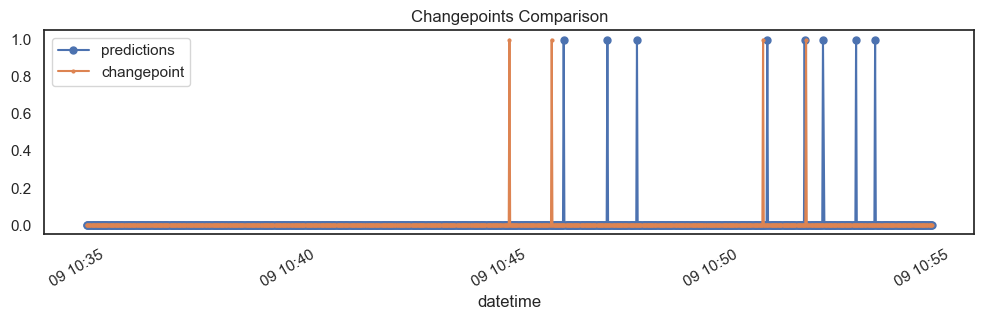

Since you not choose numenta_time and portion, then portion will be 0.1
False Alarm Rate 3.53 %
Missing Alarm Rate 40.75 %
F1 metric 0.71
Since you not choose numenta_time and portion, then portion will be 0.1
TP 3734
TN 11418
FP 418
FN 2568


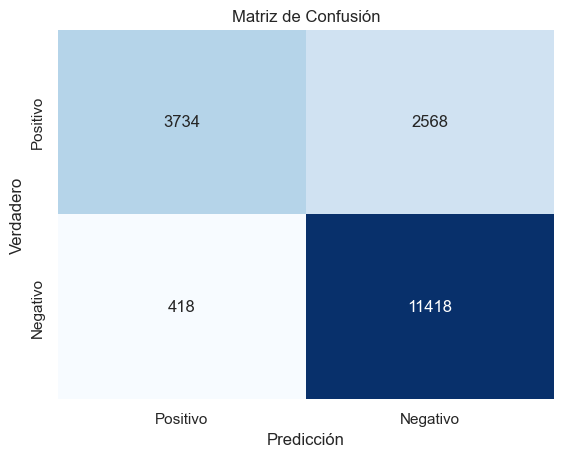

Intersection of scoring windows(Timestamp('2020-03-09 10:48:33'), Timestamp('2020-03-09 10:45:33'))
Intersection of scoring windows(Timestamp('2020-03-09 10:54:33'), Timestamp('2020-03-09 10:51:34'))
Intersection of scoring windows(Timestamp('2020-03-09 13:48:38.800000'), Timestamp('2020-03-09 13:45:39'))
Intersection of scoring windows(Timestamp('2020-03-09 13:54:38.800000'), Timestamp('2020-03-09 13:51:39'))
Intersection of scoring windows(Timestamp('2020-03-09 14:08:39'), Timestamp('2020-03-09 14:05:40'))
Intersection of scoring windows(Timestamp('2020-03-09 14:14:40'), Timestamp('2020-03-09 14:11:41'))
Intersection of scoring windows(Timestamp('2020-03-09 14:28:40'), Timestamp('2020-03-09 14:25:40'))
Intersection of scoring windows(Timestamp('2020-03-09 14:34:40'), Timestamp('2020-03-09 14:31:41'))
Intersection of scoring windows(Timestamp('2020-03-09 14:48:40.800000'), Timestamp('2020-03-09 14:45:41'))
Intersection of scoring windows(Timestamp('2020-03-09 14:54:40.800000'), Timest

In [146]:
# Trazar outliers
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

plt.figure(figsize=(12,3))  # Crea una nueva figura para los outliers
predicted_outlier[0].plot(label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend()
plt.title('Outliers Comparison')
plt.show()  # Muestra la figura de outliers

# Trazar changepoints

true_cp = [df.changepoint for df in list_of_df]

plt.figure(figsize=(12,3))  # Crea una nueva figura para los changepoints
predicted_cp[0].plot(label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend()
plt.title('Changepoints Comparison')
plt.show()  # Muestra la figura de changepoints


# binary classification metrics calculation
binary = evaluating(
    true_outlier, 
    predicted_outlier, 
    metric='binary'
)

conf_matrix = evaluating(
    true_outlier, 
    predicted_outlier, 
    metric='confusion_matrix'
)
graficar_matriz_confusion(conf_matrix)


# average detection delay metric calculation
add = evaluating(
    true_cp, 
    predicted_cp, 
    metric='average_time',
    anomaly_window_destenation='righter', 
    portion=1
)

# nab metric calculation
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='30S',
    anomaly_window_destenation='center', 
)

### Train-Test Valve2 Fault Data

In [12]:
%%time
list_of_df = valve2_df
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:500].drop(['anomaly','changepoint'], axis=1)
    
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # convert into input/output
    X = create_sequences(StSc.transform(X_train), N_STEPS)
    
    # model fitting
    # history, model = arch(X)
    model.fit(X)
    
    # results predicting
    residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)[1]), axis=1), axis=1))
    UCL = residuals.quantile(Q) * 3/2
    
    # results predicting
    X = create_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
    cnn_residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)[1]), axis=1), axis=1))
    
    # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
    anomalous_data = cnn_residuals > UCL
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)
    
    prediction = pd.Series(data=0, index=df.index)
    prediction.iloc[anomalous_data_indices] = 1
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

30/30 [==============================] - 0s 12ms/step
CPU times: total: 35.8 s
Wall time: 2min 51s


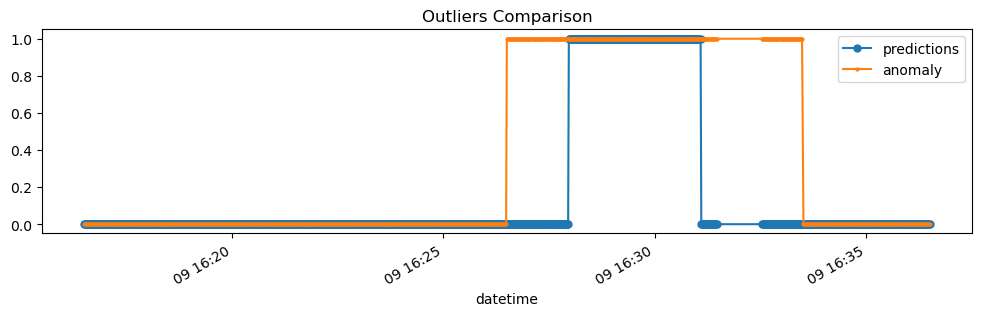

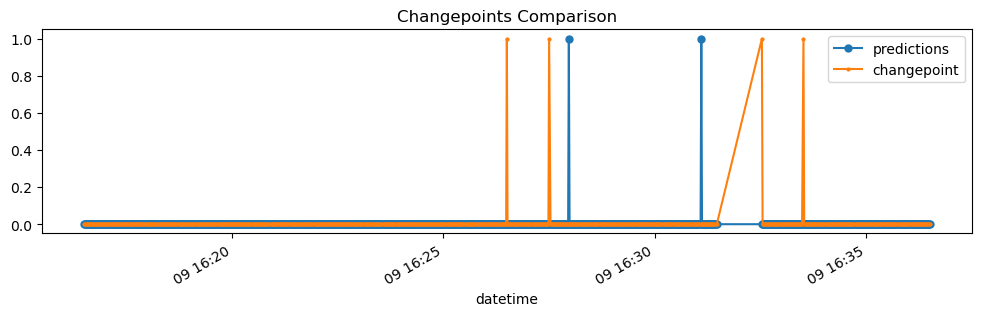

Since you not choose numenta_time and portion, then portion will be 0.1
False Alarm Rate 0.39 %
Missing Alarm Rate 30.37 %
F1 metric 0.82
Since you not choose numenta_time and portion, then portion will be 0.1
TP 782
TN 2056
FP 8
FN 341


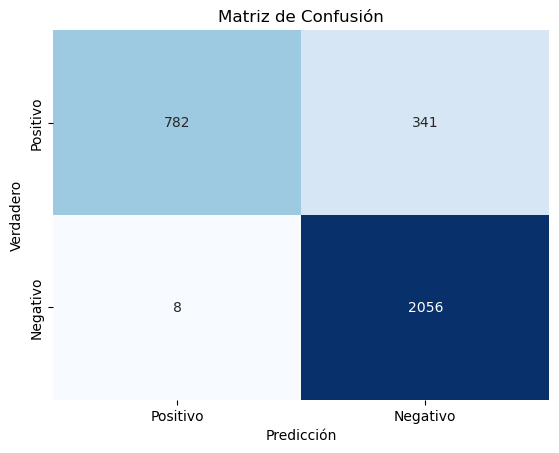

Intersection of scoring windows(Timestamp('2020-03-09 16:30:30'), Timestamp('2020-03-09 16:27:30'))
Intersection of scoring windows(Timestamp('2020-03-09 16:36:32'), Timestamp('2020-03-09 16:33:31'))
Intersection of scoring windows(Timestamp('2020-03-09 16:50:30.800000'), Timestamp('2020-03-09 16:47:31'))
Intersection of scoring windows(Timestamp('2020-03-09 16:56:30.800000'), Timestamp('2020-03-09 16:53:31'))
Intersection of scoring windows(Timestamp('2020-03-09 17:10:02.600000'), Timestamp('2020-03-09 17:07:32'))
Intersection of scoring windows(Timestamp('2020-03-09 17:16:03.600000'), Timestamp('2020-03-09 17:13:32'))
Amount of true anomalies 12
A number of missed CPs = 6
A number of FPs = 0
Average time 0 days 00:00:48.666666666
Standart  -  13.26
LowFP  -  10.03
LowFN  -  17.17


In [13]:
# Trazar outliers
n = 0
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

plt.figure(figsize=(12,3))  # Crea una nueva figura para los outliers
predicted_outlier[n].plot(label='predictions', marker='o', markersize=5)
true_outlier[n].plot(marker='o', markersize=2)
plt.legend()
plt.title('Outliers Comparison')
plt.show()  # Muestra la figura de outliers

# Trazar changepoints

true_cp = [df.changepoint for df in list_of_df]

plt.figure(figsize=(12,3))  # Crea una nueva figura para los changepoints
predicted_cp[n].plot(label='predictions', marker='o', markersize=5)
true_cp[n].plot(marker='o', markersize=2)
plt.legend()
plt.title('Changepoints Comparison')
plt.show()  # Muestra la figura de changepoints


# binary classification metrics calculation
binary = evaluating(
    true_outlier, 
    predicted_outlier, 
    metric='binary'
)

conf_matrix = evaluating(
    true_outlier, 
    predicted_outlier, 
    metric='confusion_matrix'
)
graficar_matriz_confusion(conf_matrix)


# average detection delay metric calculation
add = evaluating(
    true_cp, 
    predicted_cp, 
    metric='average_time',
    anomaly_window_destenation='righter', 
    portion=1
)

# nab metric calculation
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='30S',
    anomaly_window_destenation='center', 
)